# 6. Figure 4

This notebook is used to create the panels of Figure 4.

Before starting, use 1.Preprocessing notebook to generate:
- SC4_normalized.h5ad - Normalized single-cell data

In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import pandas as pd
import scanpy as sc
from anndata import read_h5ad, concat
from matplotlib import cm
import numpy as np
from scipy import stats
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

import sys
sys.path.insert(0, '../functions/')
import pl
import utils

### Set plot style

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats=['retina']
sns.set(rc={'figure.figsize':(5, 5),
            'legend.frameon':False},
        style='ticks',
        context='talk')

# Render figures with higher resolution.
plt.rcParams['figure.dpi']=200
# Save with transparent regions white background.
plt.rcParams['savefig.facecolor']='white'

### Set color palette

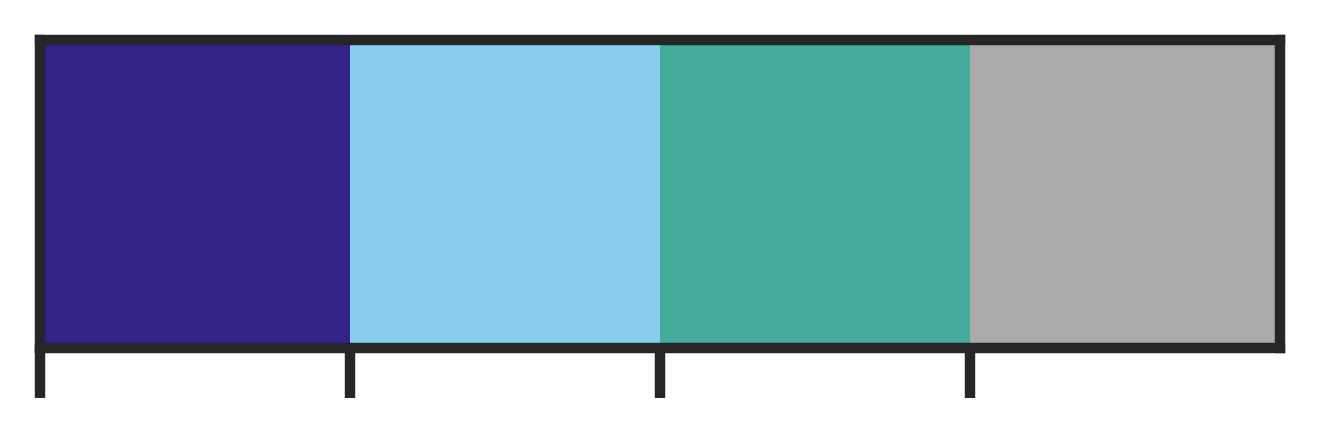

In [3]:
#color palette
palette = [(51,34,136),(136,204,238),(68,170,153),(170,170,170)]
palette = [(e[0]/255.0, e[1]/255.0, e[2]/255.0) for e in palette]
cmap = ListedColormap(palette)
sns.color_palette(palette=None,as_cmap=True)
sns.palplot(palette)

## Panel A

### Set paths

In [4]:
#input
data_dir = Path(r'../data')
masks_path = data_dir / 'SC4_Well1_cellmasks.npy'
anndata_path = data_dir / 'SC4_normalized.h5ad'

plots_path =  Path(r'../') / 'figures' / 'Figure4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [5]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata = adata[adata.obs['well']=='well1', :]

#load cell masks
labels = np.load(masks_path)

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Masks
GFP fluorescence

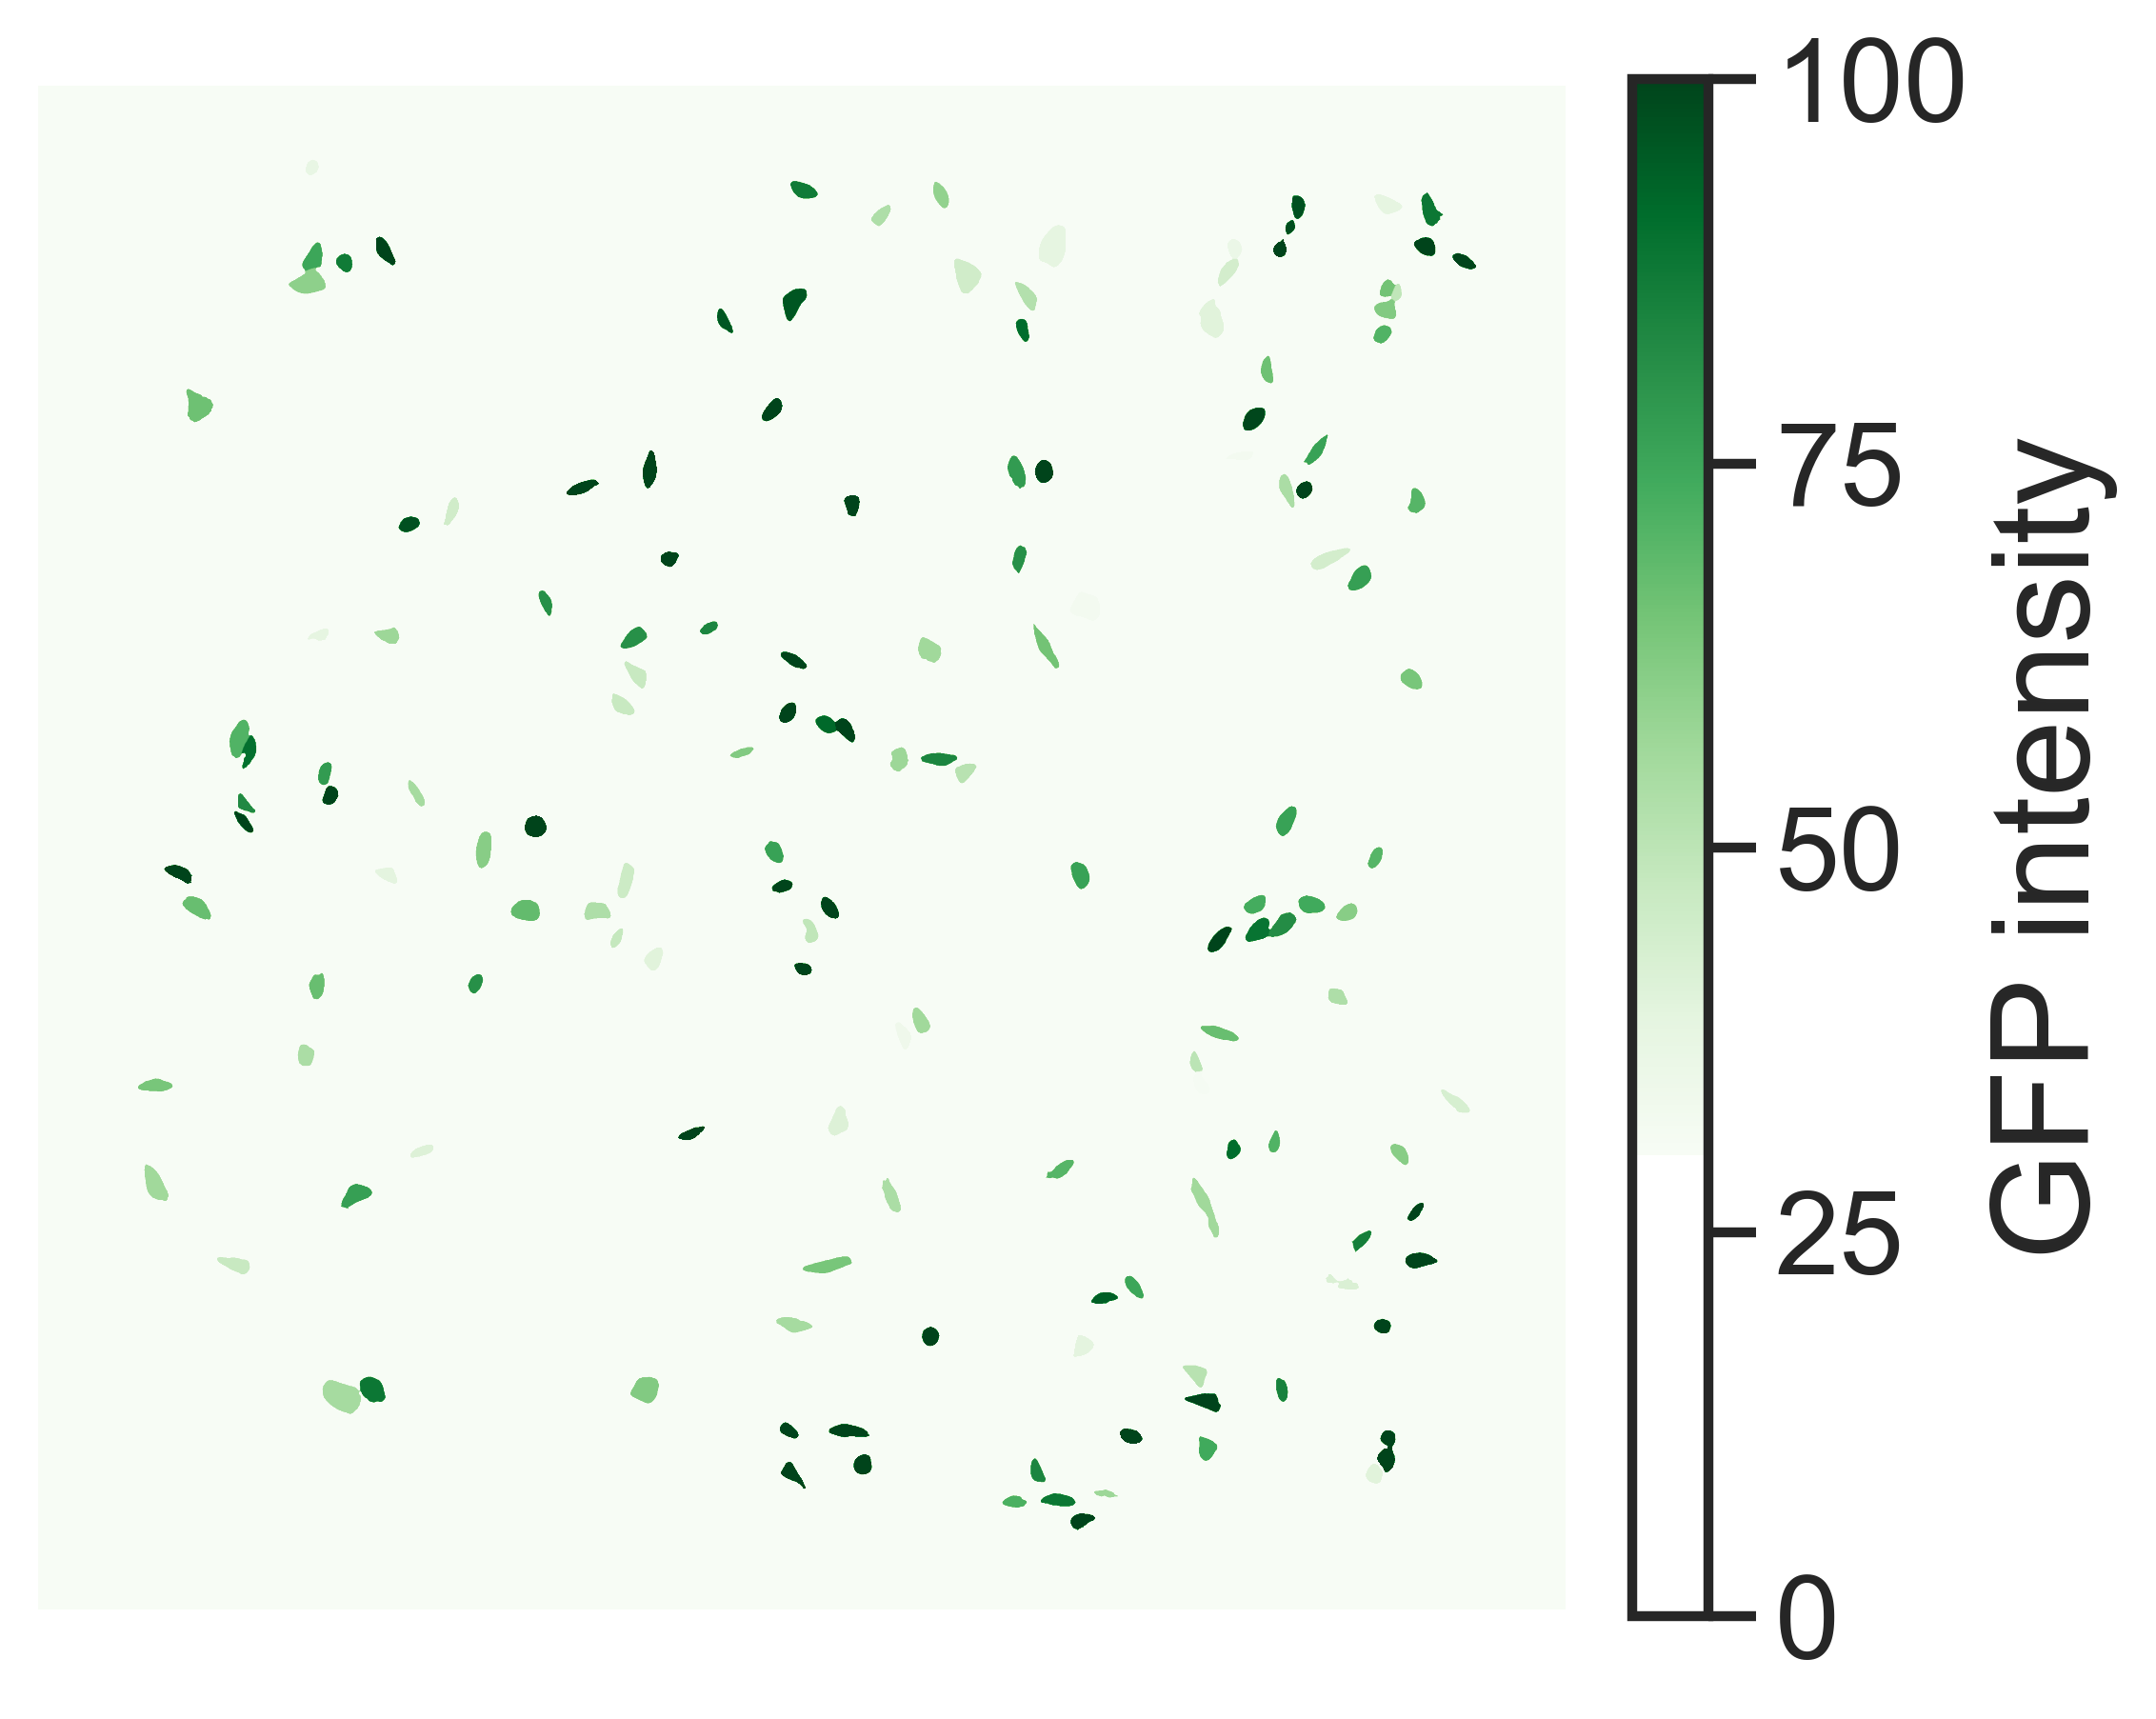

In [6]:
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels != 0] 
obs_label_ids = adata.obs_names.astype(int)
valid_labels = np.intersect1d(unique_labels, obs_label_ids)
label_to_obs = {label: str(label) for label in valid_labels}

fluo = 'sampled_intensity_max-GFP'

# Get intensity values from adata.obs
fluo_values = adata.obs[fluo].values
# Create mapping from label ID to ion intensity
label_to_ion = {label: fluo_values[np.where(obs_label_ids == label)[0][0]]
    for label in valid_labels if label in obs_label_ids.values}

colored_img = np.zeros_like(labels, dtype=np.float32)
for label, intensity in label_to_ion.items():
    colored_img[labels == label] = intensity
cmap= plt.colormaps['Greens'].copy()
cmap.set_bad(color='white')

fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
ax.set_facecolor('white')
im =ax.imshow(colored_img, cmap=cmap, vmin=30, vmax=100)#, norm=norm)#, vmin=3500, vmax = 1000) #norm=norm
plt.gca().set_facecolor('white')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(f'GFP intensity', fontsize=26)
cbar.set_ticks(np.linspace(0, 100, num=5))
cbar.ax.tick_params(labelsize=22)
ax.axis('off')
plt.tight_layout()
plt.savefig(plots_path / 'panel_A_GFP.svg', dpi=300, bbox_inches='tight')
plt.savefig(plots_path / 'panel_A_GFP.png', dpi=300, bbox_inches='tight')

Cell masks with GFP label assigned

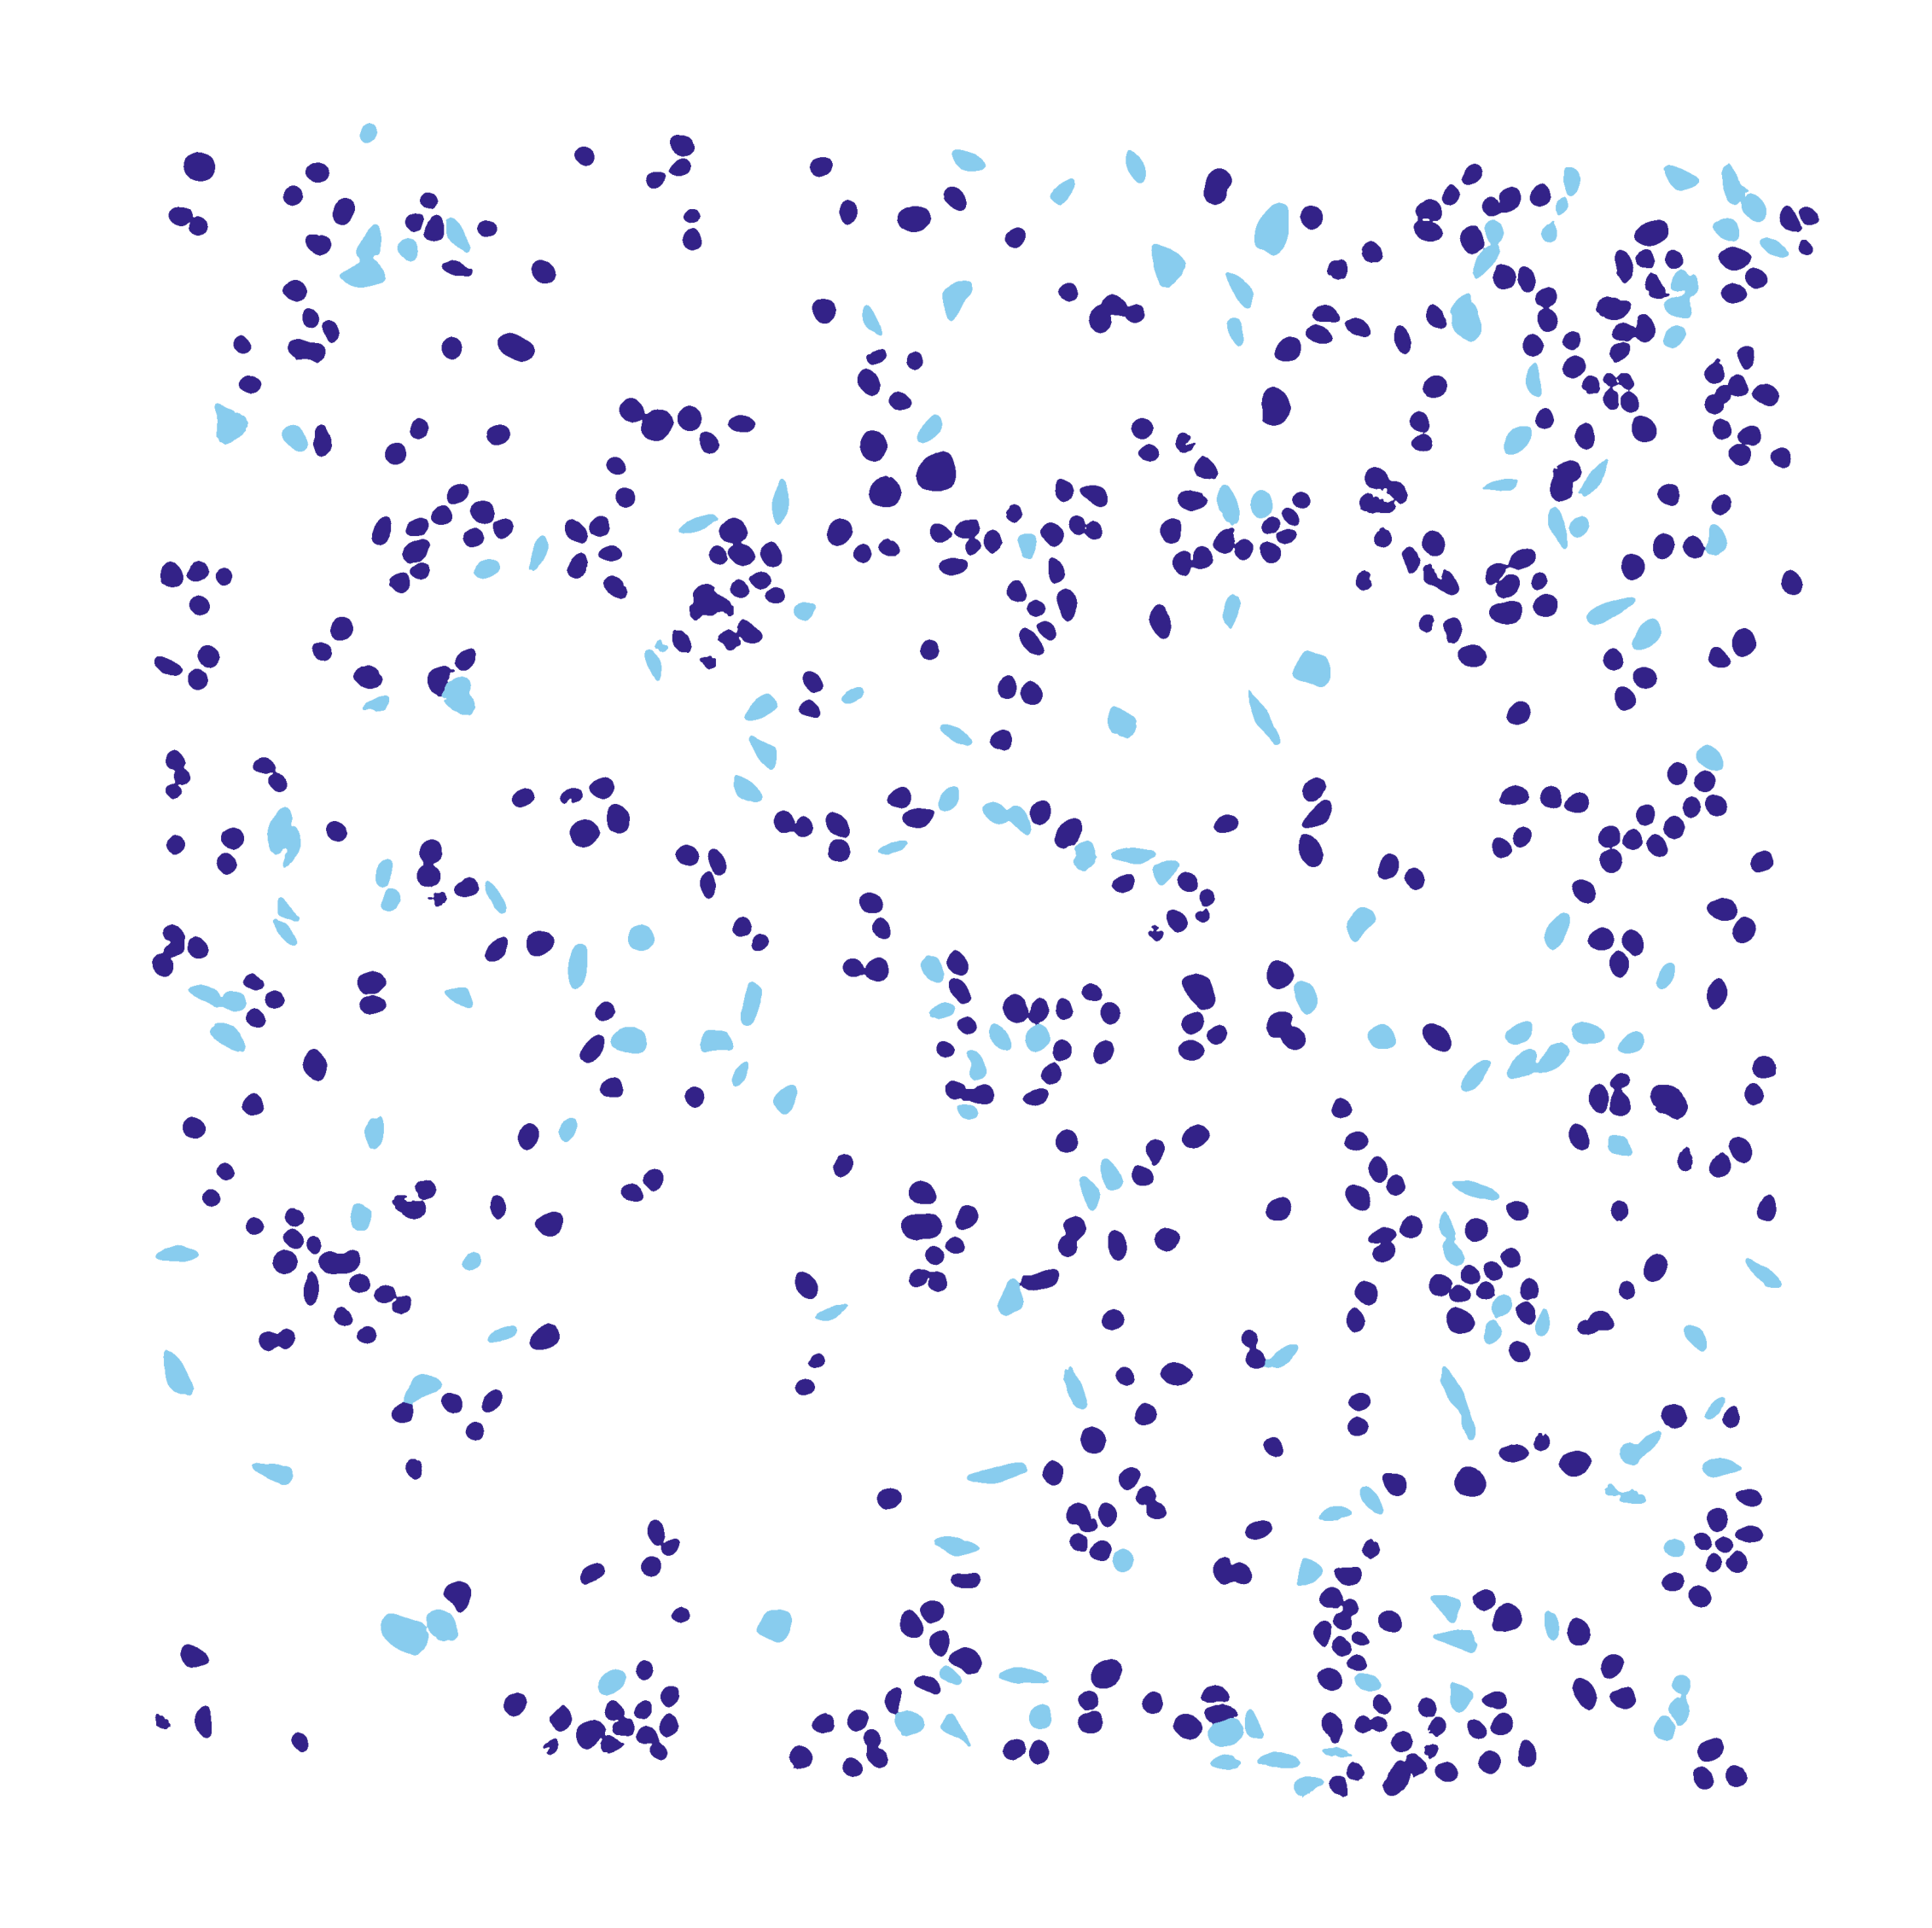

In [7]:
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels != 0]
obs_label_ids = adata.obs_names.astype(int)
valid_labels = np.intersect1d(unique_labels, obs_label_ids)
label_to_condition = {label: adata.obs.loc[str(label), 'condition_GFP'] 
    for label in valid_labels if str(label) in adata.obs.index}

# Define color palette (adjust as needed)
condition_palette = {'NIH3T3': palette[1],
                     'NCI-H460': palette[0]}

# Create RGB image with white background
colored_img_rgb = np.ones((*labels.shape, 3), dtype=np.float32)  # white background

for label, condition in label_to_condition.items():
    if condition in condition_palette:
        rgb = np.array(cm.colors.to_rgb(condition_palette[condition]))
        colored_img_rgb[labels == label] = rgb

fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
ax.set_facecolor('white')
ax.imshow(colored_img_rgb)
ax.axis('off')
plt.tight_layout()
plt.savefig(plots_path / 'panel_A_masks.svg', dpi=300, bbox_inches='tight')
plt.savefig(plots_path / 'panel_A_masks.png', dpi=300, bbox_inches='tight')

## Panel B

### Set paths

In [8]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC4_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [9]:
adata =  sc.read_h5ad(anndata_path)

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Histogram

In [10]:
fig = pl.histogram(adata=adata, column = 'sampled_intensity_max-GFP', 
                   resolution=100, bins=50, color=palette[2], limit=96, 
                   size_x=5, size_y=4, x_label='GFP intensity', threshold=10)

fig.savefig(plots_path / 'panel_B.png', bbox_inches='tight')
fig.savefig(plots_path / 'panel_B.svg', bbox_inches='tight')

## Panel C

### Set paths

In [36]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC4_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

plots_path2 =  Path(r'../') / 'figures' / 'supplementary_figure_3'
plots_path2.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path2

### Load data

In [37]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Classification

In [38]:
sc.tl.pca(adata)
sc.external.pp.bbknn(adata, batch_key='well')
sc.tl.umap(adata)

In [39]:
# Keep only strictly labeled cells
adata = adata[adata.obs['condition']!='Uncertain', :]

# Apply ComBat batch correction using 'well'
sc.pp.combat(adata, key='well')

# Subsample NCI-H460 cells to balance with NIH3T3
labels = adata.obs['condition'].values
nih3t3_mask = labels == 'NIH3T3'
ncih460_mask = labels == 'NCI-H460'

n_nih3t3 = np.sum(nih3t3_mask)
adata_nih3t3 = adata[nih3t3_mask].copy()
adata_ncih460 = adata[ncih460_mask].copy()
adata_ncih460_sub = adata_ncih460[np.random.choice(adata_ncih460.shape[0], n_nih3t3, replace=False)].copy()

# Combine balanced datasets
adata_balanced = adata_nih3t3.concatenate(adata_ncih460_sub)

# Compute expression matrix and labels after balancing
X = adata_balanced.X.toarray() if not isinstance(adata_balanced.X, np.ndarray) else adata_balanced.X
X = StandardScaler().fit_transform(X)
labels_balanced = adata_balanced.obs['condition'].values
wells = adata_balanced.obs['well'].values

# Initialize prediction array with correct size
predicted_labels = np.empty(adata_balanced.shape[0], dtype=object)

# 10-fold cross-validation calculated on balanced adata
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []
accuracies = []
conf_matrices = []

for train_idx, test_idx in skf.split(X, labels_balanced):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = labels_balanced[train_idx], labels_balanced[test_idx]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    f1_scores.append(f1_score(y_test, y_pred, pos_label='NCI-H460'))
    accuracies.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred, labels=['NIH3T3', 'NCI-H460']))

    predicted_labels[test_idx] = y_pred

# Store CV predictions in obs
adata_balanced.obs['predicted'] = predicted_labels
adata_balanced.obs['prediction_correct'] = (adata_balanced.obs[
                                            'predicted'] == adata_balanced.obs['condition']).map({
    True: 'Correct', False: 'Incorrect'})

print("\nRandom Forest Cross-Validation Results:")
print(f"Mean F1-score: {np.mean(f1_scores):.4f}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")

# Print cumulative confusion matrix
cumulative_cm = np.sum(conf_matrices, axis=0)
print("\nConfusion Matrix (Cumulative over CV folds):")
print(pd.DataFrame(cumulative_cm, index=['True NIH3T3', 'True NCI-H460'], 
                   columns=['Pred NIH3T3', 'Pred NCI-H460']))

# Compute sensitivity and specificity for NIH3T3
TP = cumulative_cm[0, 0]
FN = cumulative_cm[0, 1]
TN = cumulative_cm[1, 1]
FP = cumulative_cm[1, 0]

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

print(f"\nSensitivity (NIH3T3): {sensitivity:.4f}")
print(f"Specificity (NIH3T3): {specificity:.4f}")

# Train final classifier on assigned adata for feature importance
Y= adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
Y= StandardScaler().fit_transform(Y)
labels = adata.obs['condition'].values

clf_full = RandomForestClassifier(n_estimators=100, random_state=42)
clf_full.fit(Y, labels)

feature_names = adata.var_names
importances = clf_full.feature_importances_

# Determine which condition has higher expression
means_nih3t3 = np.mean(Y[labels == 'NIH3T3'], axis=0)
means_ncih460 = np.mean(Y[labels == 'NCI-H460'], axis=0)
higher_in = np.where(means_ncih460 > means_nih3t3, 'NCI-H460', 'NIH3T3')

# Feature importance table
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances,
    'higher_in': higher_in
}).sort_values(by='importance', ascending=False)

print("\nTop 20 Important Features:")
print(importance_df.head(20))

#Top 20 features
top_features = importance_df['feature'].head(20).values
selected_indices = [list(feature_names).index(f) for f in top_features]
Y_selected = Y[:, selected_indices]

# UMAP for cell assigned adata
umap_model = umap.UMAP(n_neighbors=100, min_dist=0.9, random_state=42)
Y_umap = umap_model.fit_transform(Y_selected)
adata.obsm['X_umap'] = Y_umap

# UMAP for balanced adata
X_selected = X[:, selected_indices]
umap_model = umap.UMAP(n_neighbors=100, min_dist=0.9, random_state=42)
X_umap = umap_model.fit_transform(X_selected)
adata_balanced.obsm['X_umap']= X_umap

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_33898/1986802101.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en


Random Forest Cross-Validation Results:
Mean F1-score: 0.8204
Mean Accuracy: 0.8136

Confusion Matrix (Cumulative over CV folds):
               Pred NIH3T3  Pred NCI-H460
True NIH3T3            386            110
True NCI-H460           75            421

Sensitivity (NIH3T3): 0.7782
Specificity (NIH3T3): 0.8488

Top 20 Important Features:
           feature  importance higher_in
115    C9H19O11P-H    0.060280    NIH3T3
32      C5H4N4O3-H    0.051202    NIH3T3
64        C6H8O7-H    0.042745    NIH3T3
132     C18H34O2-H    0.027840  NCI-H460
121  C10H14N5O7P-H    0.026207    NIH3T3
79       C6H12O6-H    0.021632    NIH3T3
135     C20H32O2-H    0.015922  NCI-H460
131     C18H32O2-H    0.015273  NCI-H460
87    C6H14O12P2-H    0.012332    NIH3T3
80       C6H12O7-H    0.009803    NIH3T3
122  C10H14N5O8P-H    0.009705    NIH3T3
74      C6H11NO4-H    0.009448    NIH3T3
25      C4H9NO4S-H    0.008192    NIH3T3
37      C5H6N2O4-H    0.008126    NIH3T3
6         C3H6O4-H    0.008085    NIH3T3


/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_33898/1986802101.py:111: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  adata.obsm['X_umap'] = Y_umap
/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.

### Feature importance

In [40]:
plt.figure(figsize=(4.5, 4.5))
ax = sns.barplot(data=importance_df.head(20),
                 x='importance',
                 y='feature',
                 orient='h',
                 hue='higher_in',
                 hue_order=['NCI-H460', 'NIH3T3'],
                 palette=palette,
                 legend=True)

ax.set_xlabel('Feature importance', fontsize=17)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=12)
ax.set_yticklabels(['GPI','Uric acid','Citric acid*','FA 18:1','Glucose*','AMP*','FA 20:4','FA 18:2',
                    'Inosine*','Gluconic acid*','GMP*','NAcT','Mevalonic acid 5-P','Aminoadipic acid*',
                     'Fructose 1,6-bisP*','Dihydroorotic acid', 'Glyceric acid','Pyrophosphate',
                     'Hypoxanthine*','Glutamine*'])
sns.despine(offset=0,trim=False, ax=ax)
plt.xticks(ticks=[0.00,0.02,0.04,0.06], fontsize=15)
ax.legend_.set_title(None)
plt.tight_layout()

plt.savefig(plots_path / 'panel_C_features.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_C_features.svg', bbox_inches='tight')

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_33898/4031485370.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.barplot(data=importance_df.head(20),
/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_33898/4031485370.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['GPI','Uric acid','Citric acid*','FA 18:1','Glucose*','AMP*','FA 20:4','FA 18:2',


### UMAPs
Predicted labels

In [41]:
custom_order=['NCI-H460', 'NIH3T3']
adata_balanced.obs['condition'] = pd.Categorical(adata_balanced.obs['condition'], categories=custom_order, ordered=True)

f = pl.highlight_scatterplot(
    data=adata_balanced,
    obsm_key='X_umap',
    hue='condition', 
    palette=palette,
    height=3,
    aspect=1.3,
    decorate_titles=False,
    trim_axes=True,
    scatter_kwargs={'s':6})

f.add_legend(markerscale=3)
f.set_titles(col_template='')

plt.xlabel('UMAP1', loc='left', fontsize=12)
plt.ylabel('UMAP2', loc='bottom', fontsize=12)

plt.savefig(plots_path / 'panel_C_UMAPcondition.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_C_UMAPcondition.svg', bbox_inches='tight')

In [42]:
custom_order=['NCI-H460', 'NIH3T3']
adata_balanced.obs['predicted'] = pd.Categorical(adata_balanced.obs['predicted'], 
                                                 categories=custom_order, ordered=True)

f = pl.highlight_scatterplot(
    data=adata_balanced,
    obsm_key='X_umap',
    hue='predicted', 
    palette=palette,
    height=3,
    aspect=1.3,
    decorate_titles=False,
    trim_axes=True,
    scatter_kwargs={'s':6})

f.add_legend(markerscale=3)
f.set_titles(col_template='')

plt.xlabel('UMAP1', loc='left', fontsize=12)
plt.ylabel('UMAP2', loc='bottom', fontsize=12)

plt.savefig(plots_path / 'panel_C_UMAPpredicted.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_C_UMAPpredicted.svg', bbox_inches='tight')

### Supplementary Figure 3 - panel C 

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


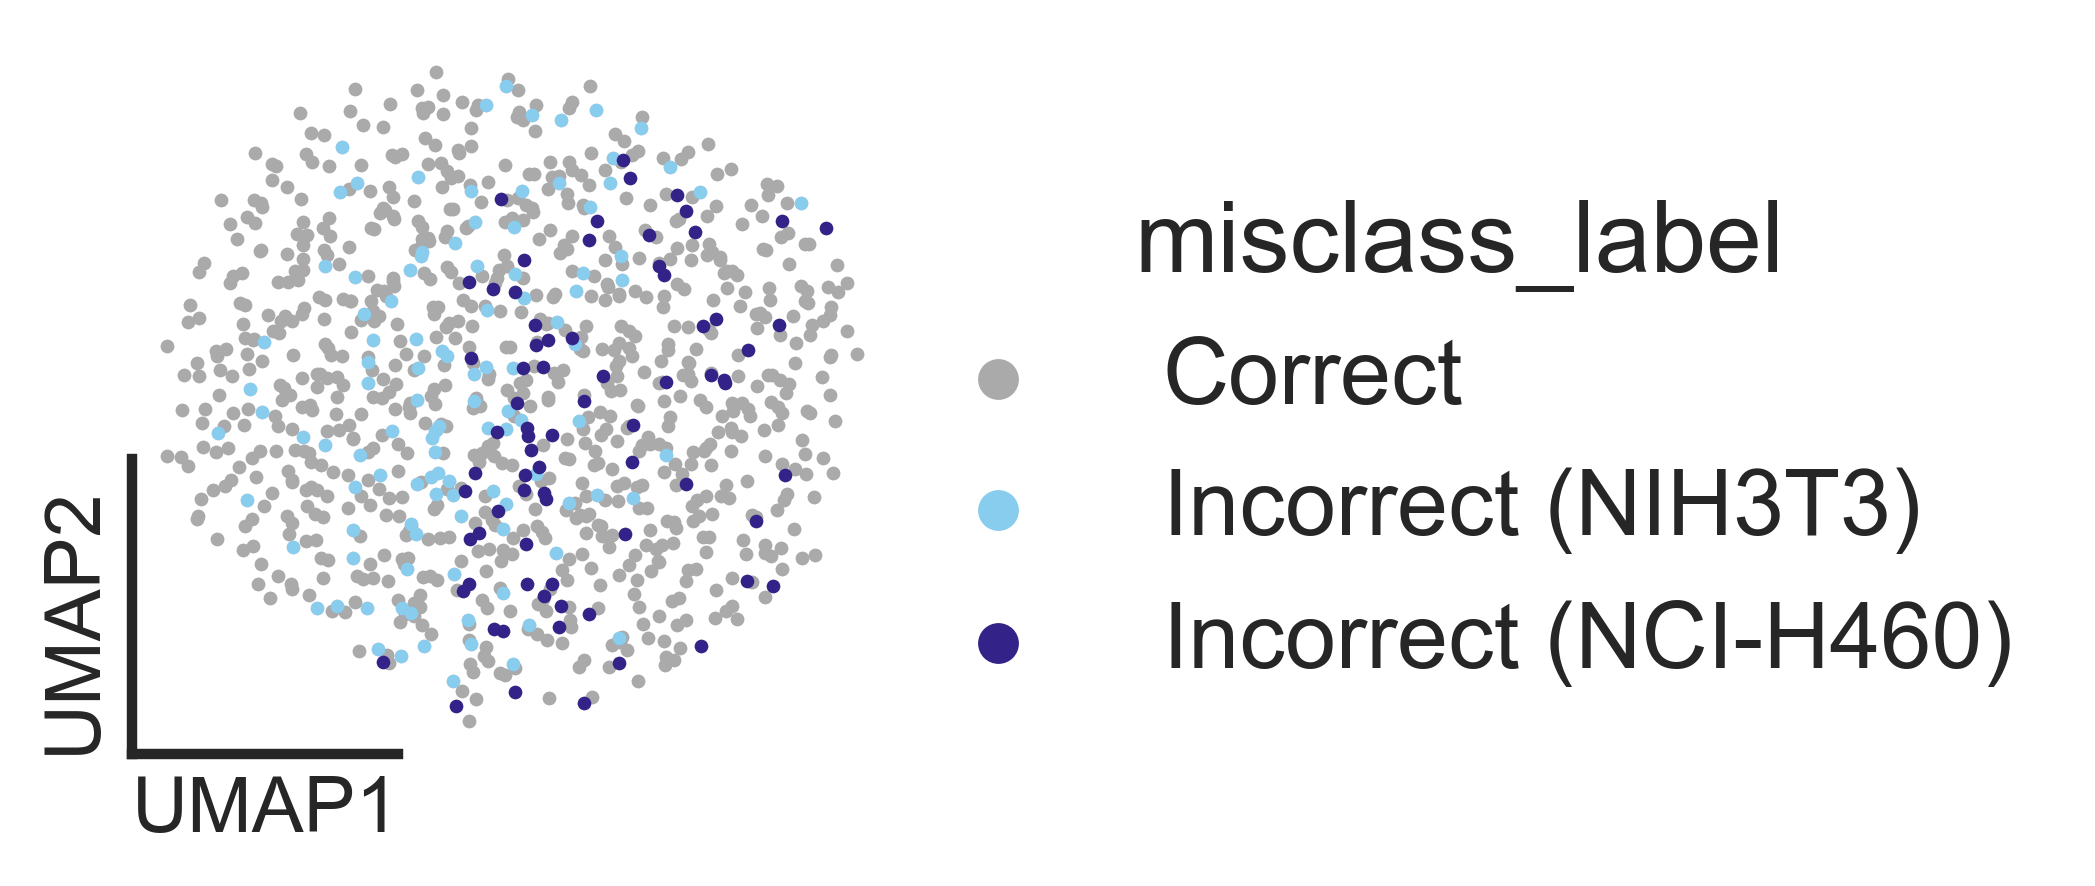

In [44]:
def misclass_label(row):
    if row['prediction_correct'] == 'Correct':
        return 'Correct'
    elif row['condition'] == 'NIH3T3':
        return 'Incorrect (NIH3T3)'
    else:
        return 'Incorrect (NCI-H460)'

adata_balanced.obs['misclass_label'] = adata_balanced.obs.apply(misclass_label, axis=1)

# Step 2: Define custom colors
color_map = {'Correct': palette[3],'Incorrect (NIH3T3)': palette[1],'Incorrect (NCI-H460)': palette[0]}
order_map = {'Correct': 0,'Incorrect (NIH3T3)': 1,'Incorrect (NCI-H460)': 2}

# Create a new column to track plotting order
adata_balanced.obs['plot_order'] = adata_balanced.obs['misclass_label'].map(order_map)
sorted_idx = np.argsort(adata_balanced.obs['plot_order'].values)
adata_sorted = adata_balanced[sorted_idx].copy()

f = pl.highlight_scatterplot(
    data=adata_sorted,
    obsm_key='X_umap',
    hue='misclass_label', 
    palette=color_map,
    height=3,
    aspect=1.4,
    decorate_titles=False,
    trim_axes=True,
    scatter_kwargs={'s':6})

f.add_legend(markerscale=3)
f.set_titles(col_template='')

plt.xlabel('UMAP1', loc='left', fontsize=14)
plt.ylabel('UMAP2', loc='bottom', fontsize=14)

plt.savefig(plots_path2 / 'panel_C.png', bbox_inches='tight')
plt.savefig(plots_path2 / 'panel_C.svg', bbox_inches='tight')

## Panel D

### Set path

In [45]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC4_normalized.h5ad'
masks_path = data_dir / 'SC4_Well1_cellmasks.npy'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_4'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [46]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)

#load cell masks
labels = np.load(masks_path)

/Users/jeanydelafiori/Apps/miniconda3/envs/spacem_analysis/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [47]:
sc.tl.pca(adata)
sc.external.pp.bbknn(adata, batch_key='well')
sc.tl.umap(adata)

### UMAP and Violin

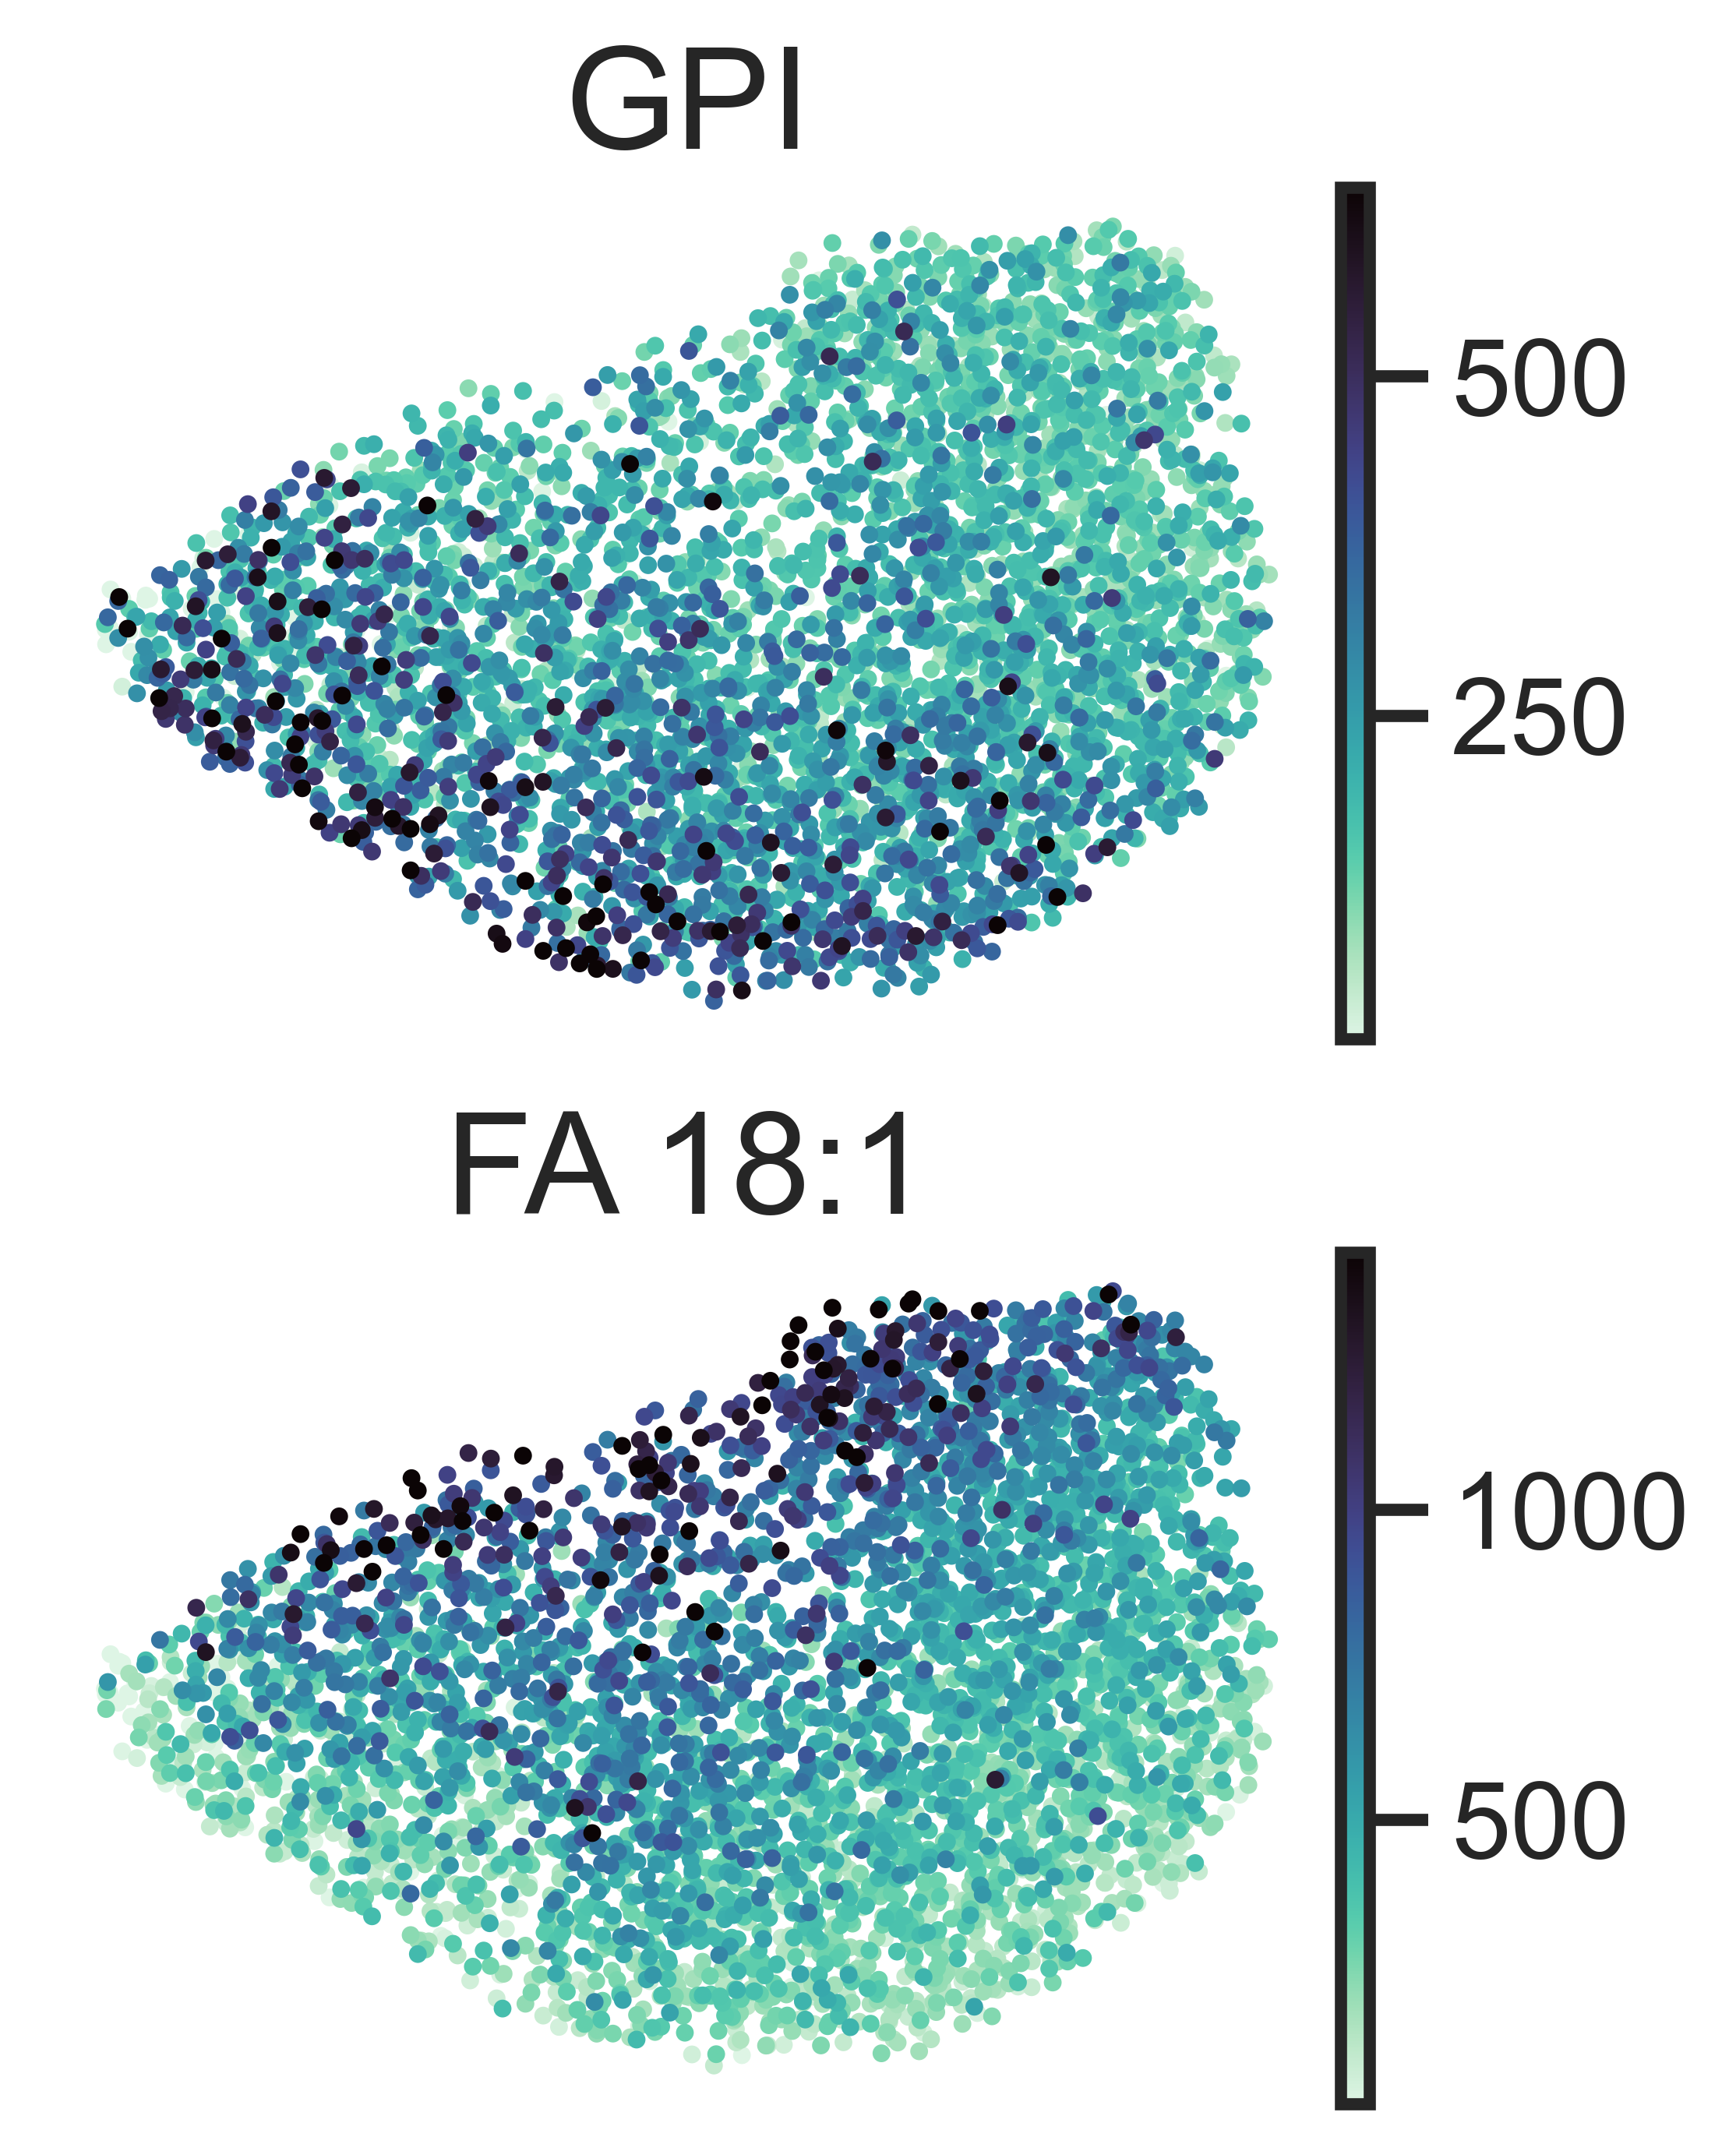

In [48]:
lower, upper = np.quantile(adata.layers['norm_counts'], [0.01, 0.99], axis=0)
adata.layers['clipped'] = np.clip(adata.layers['norm_counts'], lower, upper)

markers = ['C9H19O11P-H', 'C18H34O2-H']

with plt.rc_context({'figure.figsize':(3, 2.5),  'figure.dpi':(300), 'axes.titlesize':22, 'legend.fontsize':22}):
    f = sc.pl.umap(adata,
                   color= markers,
                   cmap='mako_r',
                   s=30,
                   layer='clipped',
                   frameon=False,
                   ncols=1,
                   title=['GPI', 'FA 18:1'],
                   show=True,
                   return_fig=True)
    plt.savefig(plots_path / 'panel_D_UMAP.png', bbox_inches='tight')
    plt.savefig(plots_path / 'panel_D_UMAP.svg', bbox_inches='tight')

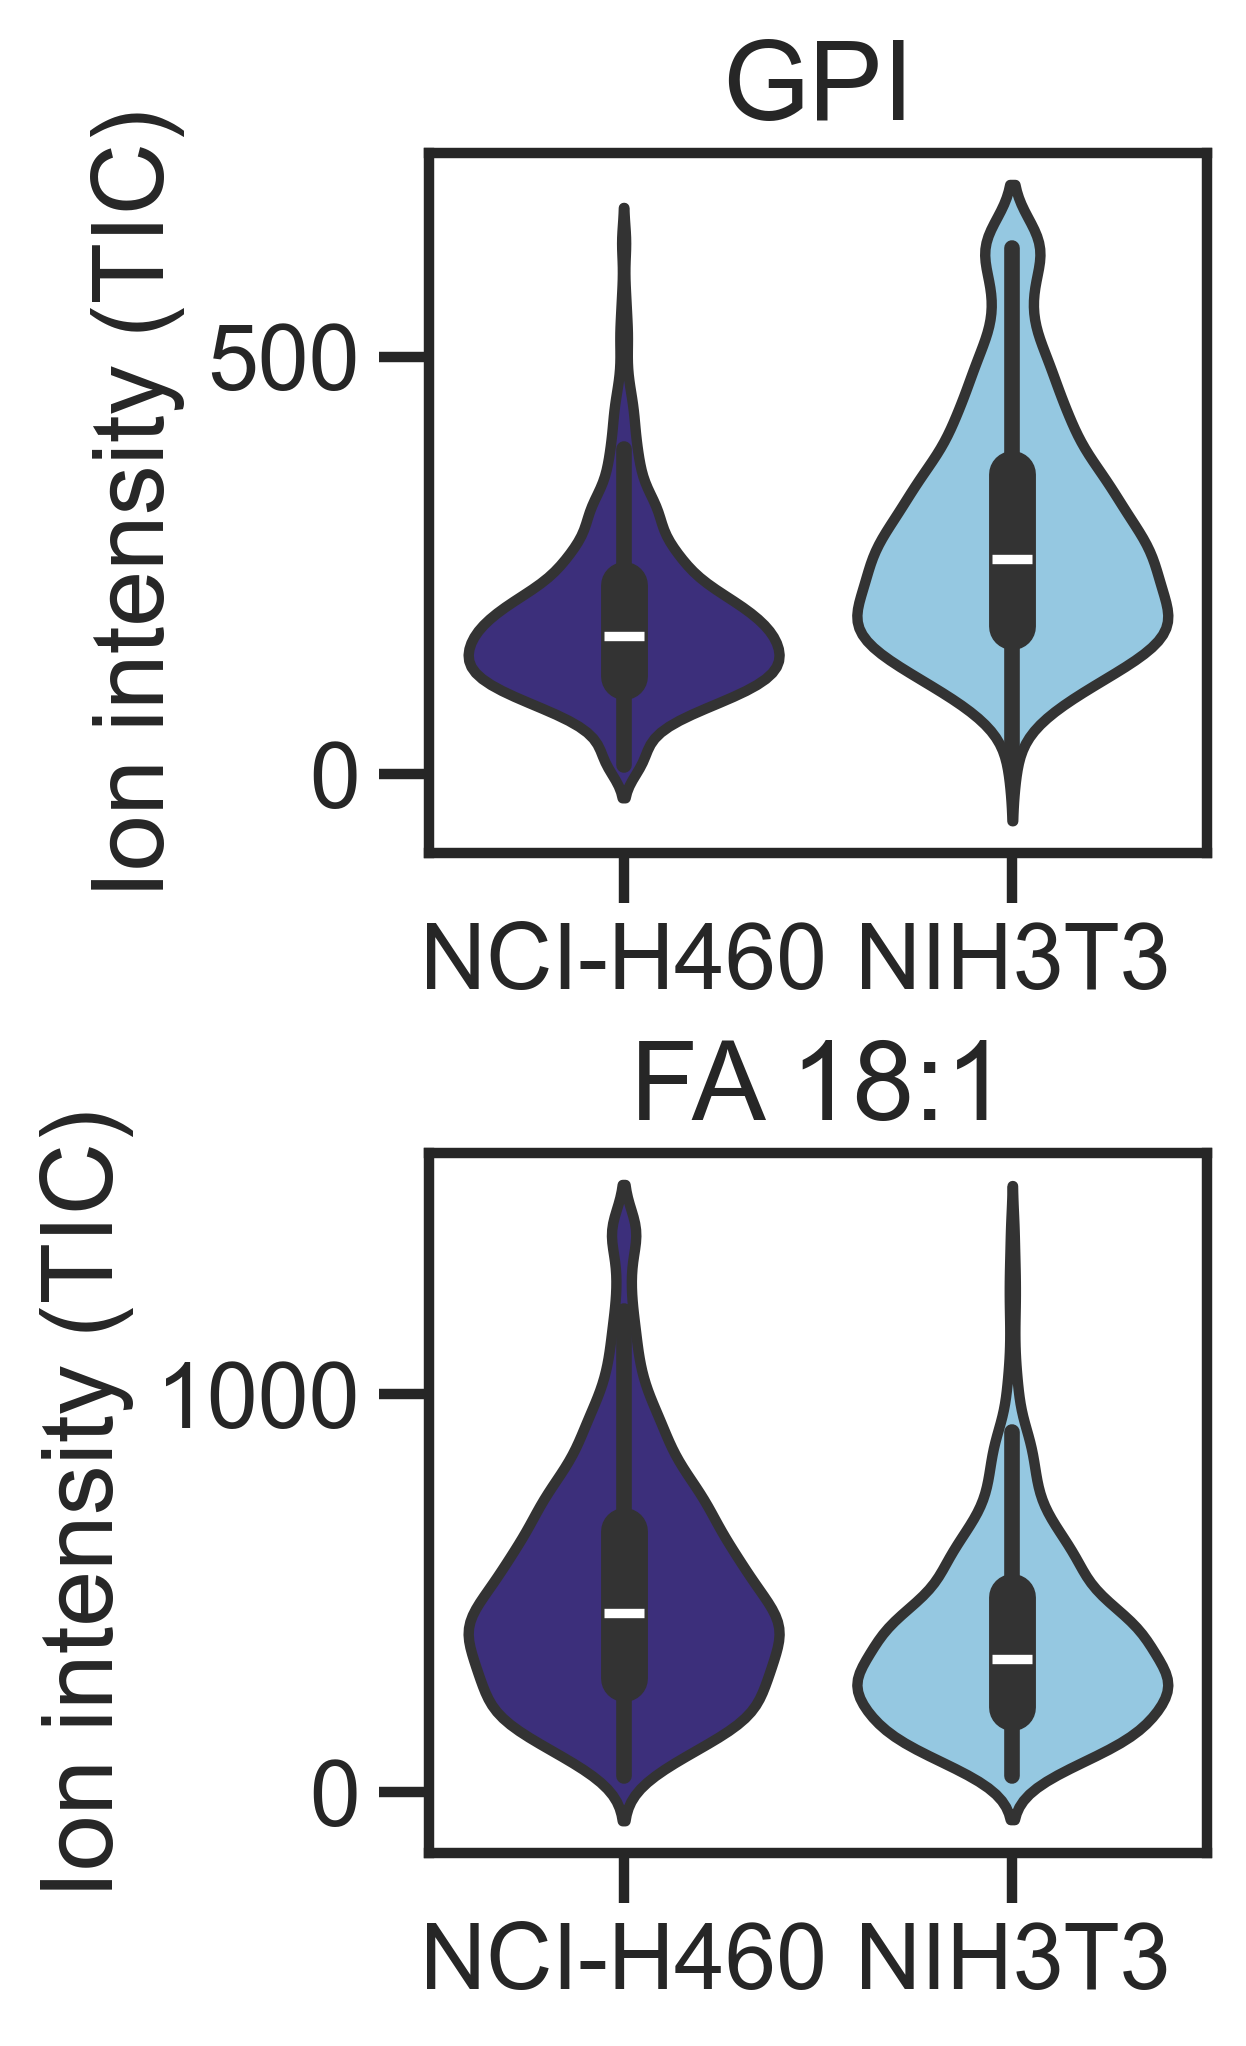

In [49]:
custom_order = ['NCI-H460', 'NIH3T3']
lower, upper = np.quantile(adata.layers['norm_counts'], [0.01, 0.99], axis=0)
adata.layers['clipped'] = np.clip(adata.layers['norm_counts'], lower, upper)

markers = ['C9H19O11P-H', 'C18H34O2-H']
ion_name_map = {'C9H19O11P-H': 'GPI','C18H34O2-H': 'FA 18:1'}

# Setup grid: 5 rows × 4 columns
fig, axes = plt.subplots(2, 1, figsize=(3, 5), constrained_layout=True)
axes = axes.flatten()

for i, ion in enumerate(markers):
     ax = axes[i]
     data = adata.to_df(layer='clipped')[ion]
     conds = adata.obs['condition_GFP']

        # Seaborn violin plot
     sns.violinplot(x=conds, y=data, palette=palette[0:2], ax=ax, order=custom_order,hue=conds)
     ion_display_name = ion_name_map.get(ion, ion)  # fallback to original name if not found
     ax.set_title(ion_display_name, fontsize=20)
     ax.set_xlabel("")
     ax.set_ylabel("Ion intensity (TIC)", fontsize=18)

     plt.savefig(plots_path / 'panel_D_violin.png', bbox_inches='tight')
     plt.savefig(plots_path / 'panel_D_violin.svg', bbox_inches='tight')

### Cell masks

In [50]:
adata1 = adata[adata.obs['well']=='well1', :]

In [51]:
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels != 0] 

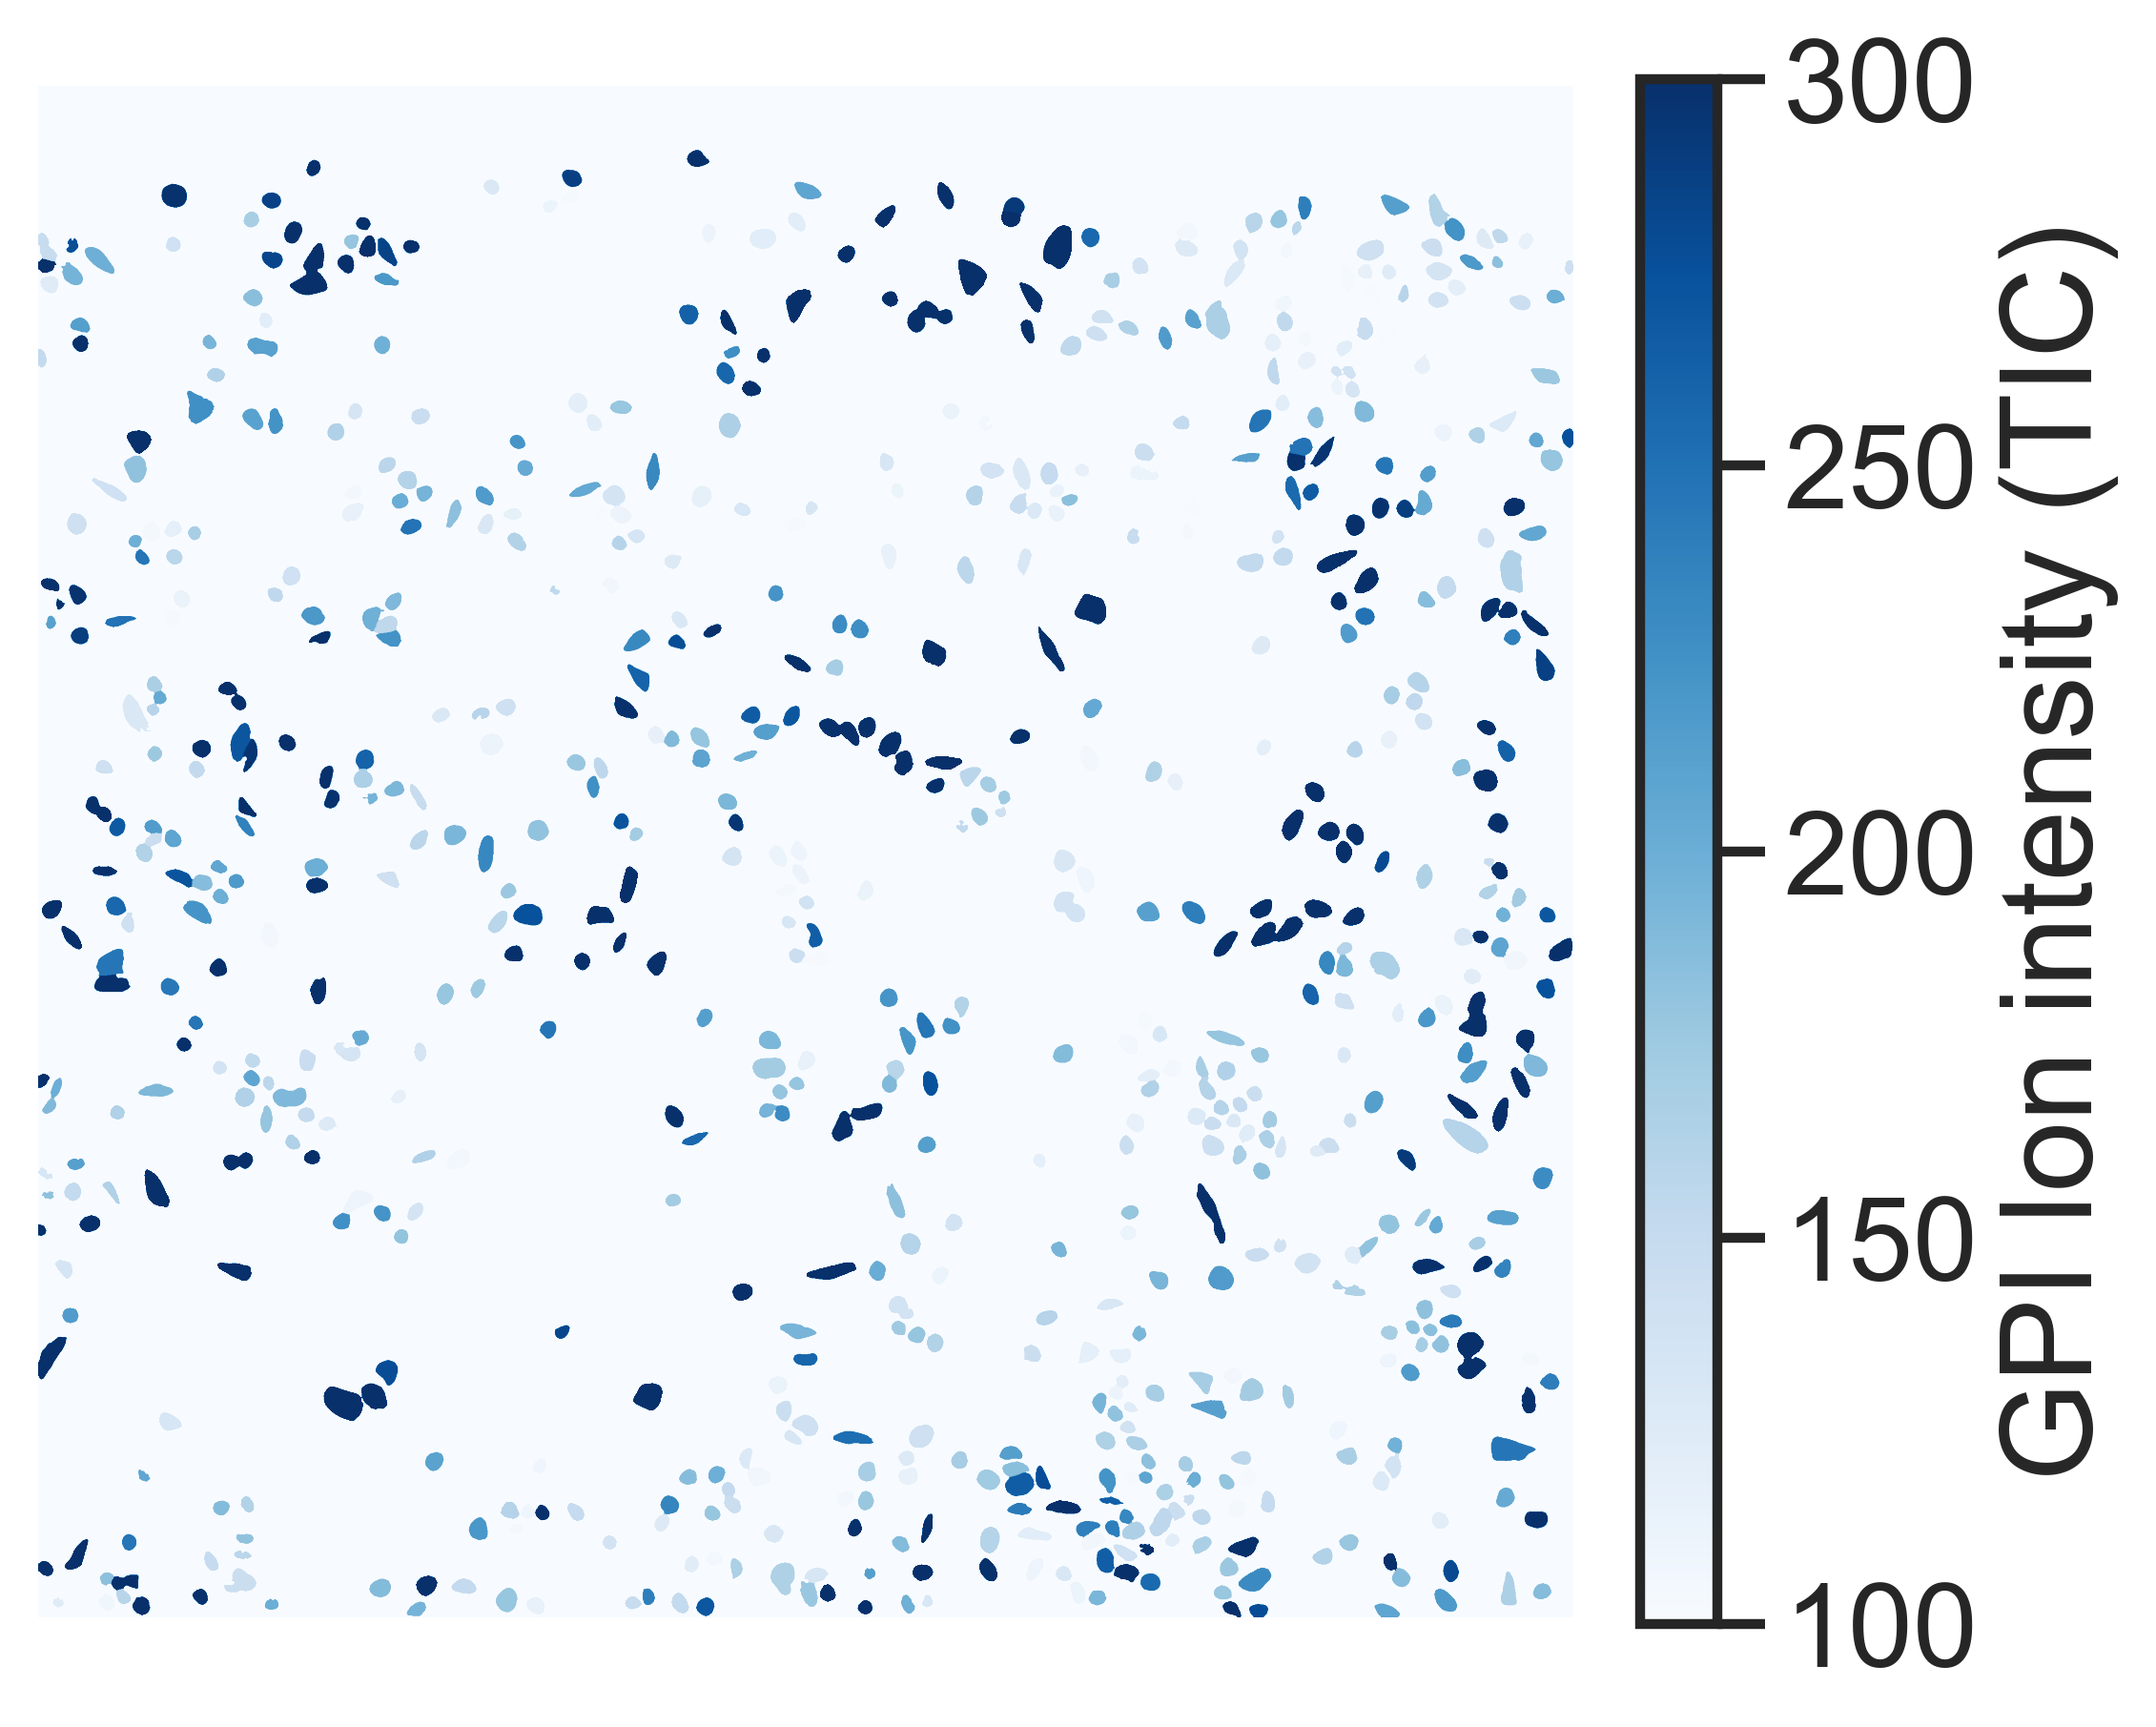

In [52]:
obs_label_ids = adata.obs_names.astype(int)
valid_labels = np.intersect1d(unique_labels, obs_label_ids)
label_to_obs = {label: str(label) for label in valid_labels}

ion_name = 'C9H19O11P-H'

# Get ion index
ion_idx = list(adata.var_names).index(ion_name)

# Grab the intensity values from adata.X for that ion
ion_values = adata.layers['norm_counts'][:, ion_idx].flatten()

# Map label IDs to ion values — only for valid labels
label_to_ion = {label: ion_values[np.where(obs_label_ids == label)[0][0]]
    for label in valid_labels if label in obs_label_ids.values}

colored_img = np.zeros_like(labels, dtype=np.float32)

for label, intensity in label_to_ion.items():
    colored_img[labels == label] = intensity

cmap= plt.colormaps['Blues'].copy()
cmap.set_bad(color='white')

fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
ax.set_facecolor('white')

im =ax.imshow(colored_img, cmap=cmap, vmax=300, vmin=100)#, norm=norm)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(fontsize=24, label=f'GPI Ion intensity (TIC)')
cbar.set_ticks(np.linspace(100, 300, num=5))
cbar.ax.tick_params(labelsize=22)


ax.axis('off')
plt.tight_layout()
plt.savefig(plots_path / 'panel_D_C9H19O11P-H.svg', dpi=300, bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_C9H19O11P-H.png', dpi=300, bbox_inches='tight')

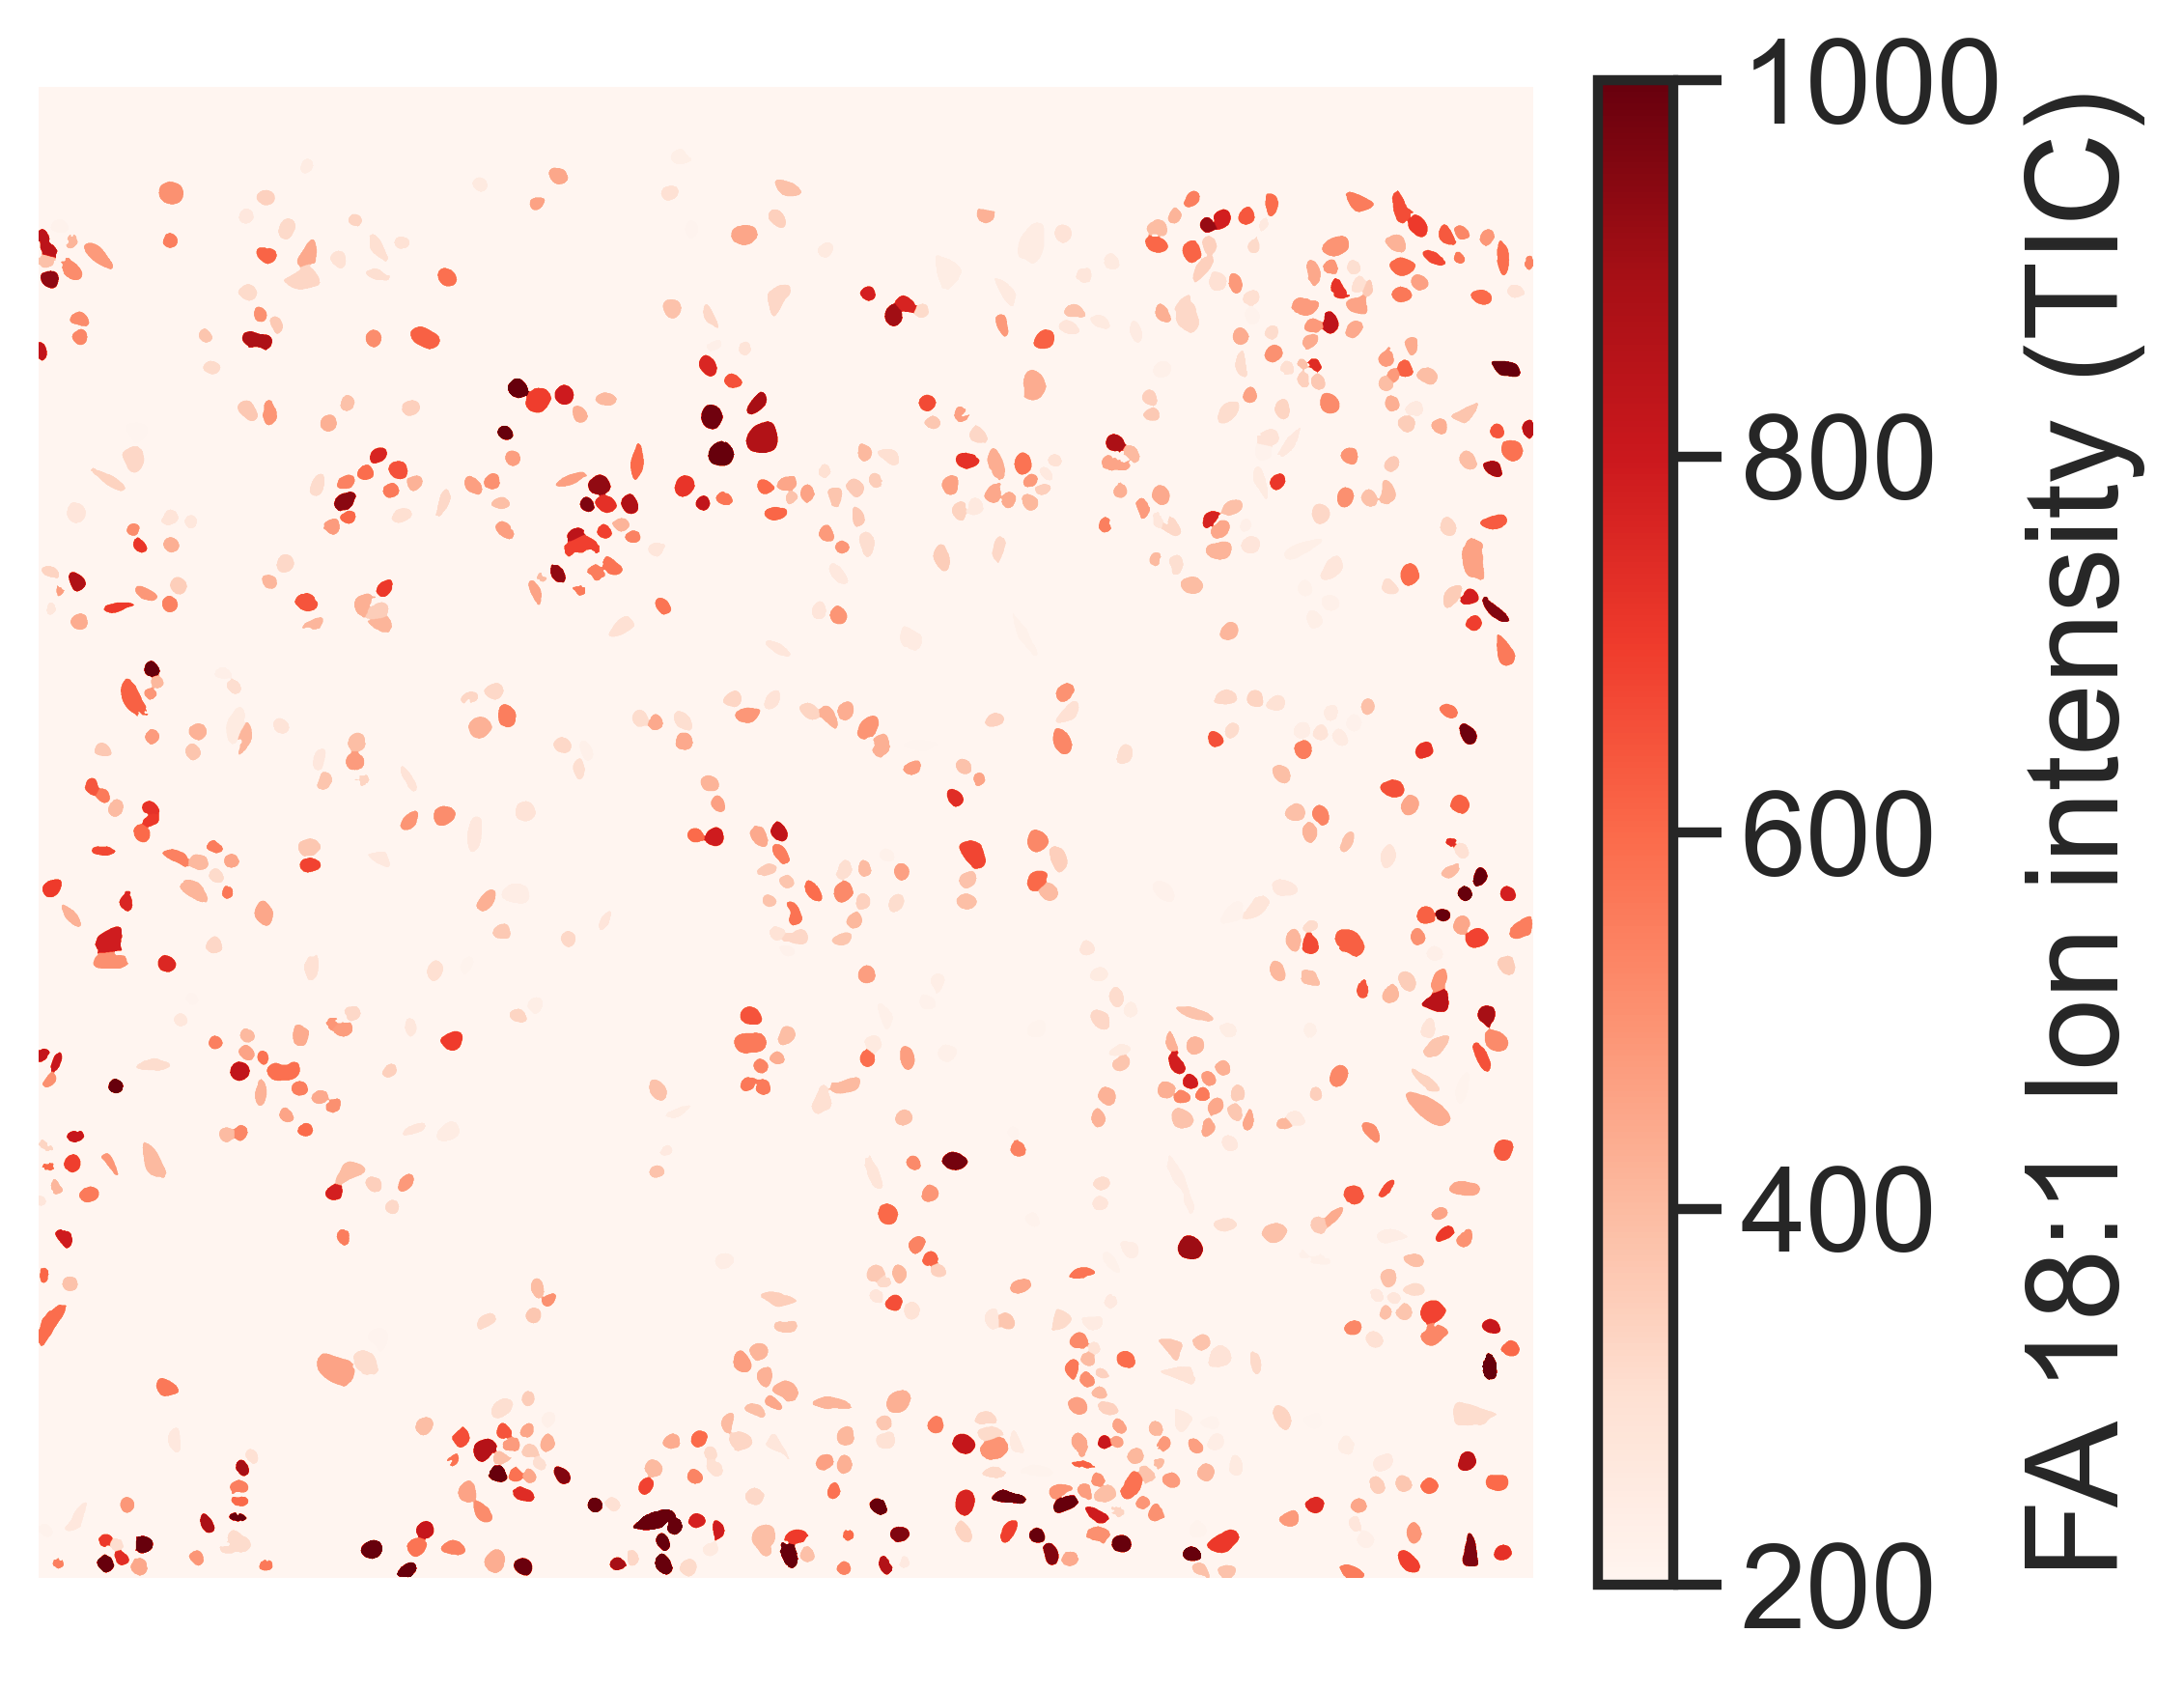

In [53]:
obs_label_ids = adata.obs_names.astype(int)
valid_labels = np.intersect1d(unique_labels, obs_label_ids)
label_to_obs = {label: str(label) for label in valid_labels}

ion_name = 'C18H34O2-H'

# Get ion index
ion_idx = list(adata.var_names).index(ion_name)

# Grab the intensity values from adata.X for that ion
ion_values = adata.layers['norm_counts'][:, ion_idx].flatten()

# Map label IDs to ion values — only for valid labels
label_to_ion = {label: ion_values[np.where(obs_label_ids == label)[0][0]]
    for label in valid_labels if label in obs_label_ids.values}

colored_img = np.zeros_like(labels, dtype=np.float32)

for label, intensity in label_to_ion.items():
    colored_img[labels == label] = intensity

cmap= plt.colormaps['Reds'].copy()
cmap.set_bad(color='white')

fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
ax.set_facecolor('white')

im =ax.imshow(colored_img, cmap=cmap, vmax=1000, vmin=200)#, norm=norm)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(fontsize=24, label=f'FA 18:1 Ion intensity (TIC)')
cbar.set_ticks(np.linspace(1000, 200, num=5))
cbar.ax.tick_params(labelsize=22)

ax.axis('off')
plt.tight_layout()
plt.savefig(plots_path / 'panel_D_C18H34O2-H.svg', dpi=300, bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_C18H34O2-H.png', dpi=300, bbox_inches='tight')